In [1]:
#Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import seaborn as sns 
import tensorflow as tf
import keras
import os
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

In [2]:
# Importing the data

import os
from PIL import Image


"""
  Below function creates a DataFrame with image paths, labels, and actual images from the provided file path parameter - 'data_dir'
"""


def image_dataframe(data_dir):
  data = []
  # Iterating through each class folder within the 'data_dir' directory
  for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
      
    for filename in os.listdir(class_path):
      if filename.endswith('.png'):
        image_path = os.path.join(class_path, filename)
        try:
          image = Image.open(image_path) 
          data.append({'image_path': image_path, 'label': class_folder, 'image': image})
        except Exception as e:
          print(f"Error loading image: {image_path} - {e}") 

  return pd.DataFrame(data)

'''
Note: The above UDF (User Defined Function) is created to handle exceptions where the file at path cannot be loaded as a image
'''

'\nNote: The above UDF (User Defined Function) is created to handle exceptions where the file at path cannot be loaded as a image\n'

In [3]:
# Defining the train directory of 'Plant-Seedlings' dataset which will be then passed to the function - 'image_dataframe()'
train_dir = '/kaggle/input/plant-seedlings/plant-seedlings-classification/train'

#Creating a df from the UDF - image_dataframe()

df = image_dataframe(train_dir)

In [4]:
# First few rows of the DataFrame

df.head()

,image_path,label,image
0,/kaggle/input/plant-seedlings/plant-seedlings-...,Scentless Mayweed,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,/kaggle/input/plant-seedlings/plant-seedlings-...,Scentless Mayweed,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,/kaggle/input/plant-seedlings/plant-seedlings-...,Scentless Mayweed,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,/kaggle/input/plant-seedlings/plant-seedlings-...,Scentless Mayweed,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,/kaggle/input/plant-seedlings/plant-seedlings-...,Scentless Mayweed,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [7]:
 """
Task - Displaying a specified number of random images from the DataFrame.

Approach - Below function display_random_images takes in a number - n (default value set to 5) and datafram 'df' created above
           This finction then prints the specified number of 'n' images chosen randomly from the datafram - 'df'   
"""



import random

def display_random_images(df, n=5):
  fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 3))
  fig.tight_layout()

  for i in range(n):
    # Selecting a random row from the DataFrame
    random_row = df.sample(1) 
    image = random_row['image'].values[0]
    label = random_row['label'].values[0]

    # Displaying the image
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off') 

  plt.show()

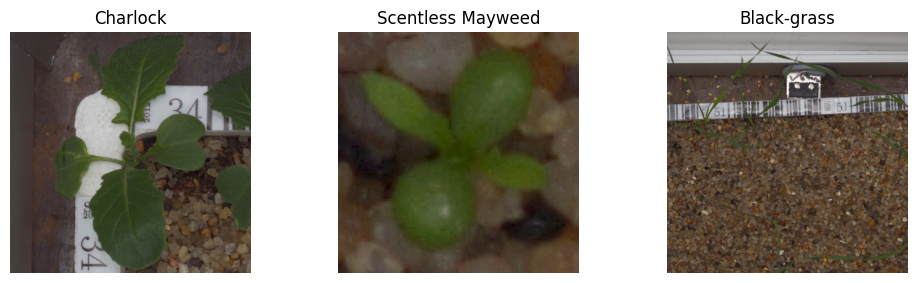

In [8]:
## Using the previosly defined UDF - 'display_random_images()' and printing 3 images
display_random_images(df, n=3)

In [9]:
# Creating X & Y from the DataFrame

X = df['image'].values 
y = df['label'].values

In [10]:
print(X, "\nLength of X is:", len(X), "\n\n\n", y, "\nLength of y is:", len(y))

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=142x142 at 0x79F79AEBBE80>
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=337x337 at 0x79F79AEBBBB0>
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=86x86 at 0x79F79AD3CDC0>
 ...
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=109x109 at 0x79F79A2223B0>
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=473x473 at 0x79F79A222410>
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=597x597 at 0x79F79A222470>] 
Length of X is: 4750 


 ['Scentless Mayweed' 'Scentless Mayweed' 'Scentless Mayweed' ...
 'Shepherds Purse' 'Shepherds Purse' 'Shepherds Purse'] 
Length of y is: 4750


In [11]:
#Encoding labels of the images

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([8, 8, 8, ..., 9, 9, 9])

In [13]:
# Unifying all the images

target_size = (224, 224)
X_resized = []

for image in X:
        # Converting all the images to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB') 

        # Resizing the image
        resized_image = image.resize(target_size, resample=Image.NEAREST) 

        # Converting it into a NumPy array
        resized_image_array = np.array(resized_image) 

        # Checking for consistency in shape (3 channels for RGB)
        if resized_image_array.shape[-1] != 3:
            resized_image_array = np.stack((resized_image_array,) * 3, axis=-1) 

        X_resized.append(resized_image_array)

X_resized = np.array(X_resized)

In [14]:
X_resized[1,1]

array([[125, 121, 127],
       [130, 126, 130],
       [130, 126, 130],
       [131, 127, 129],
       [134, 129, 131],
       [131, 126, 128],
       [132, 126, 130],
       [138, 133, 140],
       [149, 147, 154],
       [182, 186, 191],
       [186, 191, 195],
       [199, 202, 206],
       [196, 199, 203],
       [192, 196, 198],
       [191, 193, 195],
       [154, 145, 148],
       [145, 132, 135],
       [138, 130, 131],
       [145, 139, 139],
       [135, 130, 130],
       [136, 133, 132],
       [135, 130, 130],
       [130, 123, 125],
       [142, 131, 136],
       [156, 148, 154],
       [179, 179, 185],
       [182, 185, 191],
       [186, 190, 195],
       [187, 191, 197],
       [184, 186, 194],
       [190, 191, 198],
       [191, 192, 199],
       [188, 190, 197],
       [185, 188, 197],
       [186, 189, 198],
       [186, 189, 199],
       [187, 189, 198],
       [186, 188, 197],
       [186, 187, 195],
       [186, 188, 195],
       [187, 188, 195],
       [183, 186

In [15]:
#Normalizing all the images

X_normalized = X_resized / 255.0

## Model Training

In [16]:
#First, checking the shape of "X_normalized"

X_normalized.shape

(4750, 224, 224, 3)

In [17]:
#Splitting the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=79)

In [18]:
print("Shape of X_train is:", X_train.shape, "\n\nShape of X_test is:", X_test.shape, "\n\nShape of y_train is:", y_train.shape, "\n\nShape of y_test is:", y_test.shape)

Shape of X_train is: (3800, 224, 224, 3) 

Shape of X_test is: (950, 224, 224, 3) 

Shape of y_train is: (3800,) 

Shape of y_test is: (950,)


In [19]:
# Creating a new CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

batch_size = 32 

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(len(np.unique(y_encoded)), activation='softmax')) 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.1450 - loss: 2.5087 - val_accuracy: 0.3947 - val_loss: 1.8104
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3552 - loss: 1.8587 - val_accuracy: 0.4979 - val_loss: 1.5786
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4655 - loss: 1.5683 - val_accuracy: 0.5800 - val_loss: 1.2632
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5226 - loss: 1.3367 - val_accuracy: 0.6137 - val_loss: 1.0897
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5757 - loss: 1.2170 - val_accuracy: 0.6453 - val_loss: 1.0720
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5951 - loss: 1.1283 - val_accuracy: 0.6768 - val_loss: 0.9836
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6387 - loss: 1.0148 - val_accuracy: 0.6147 - val_loss: 1.1320
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6492 - loss: 1.0235 - val_acc

* The accuracy of the model on training set seems to ~70% while on the test set is at ~74% 

In [22]:
#Selecting a random image and print actual label and predicted label for the same


# Random index selection
random_index = random.randint(0, len(X_test) - 1)


# Getting the above random image and its actual label

random_image = X_test[random_index]
actual_label = le.inverse_transform([y_test[random_index]])[0] 

# Making the prediction using the CNN model

prediction = model.predict(np.expand_dims(random_image, axis=0)) 
predicted_label = le.inverse_transform(np.argmax(prediction, axis=1))[0]

print("Actual Label:", actual_label)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Actual Label: Fat Hen
Predicted Label: Fat Hen


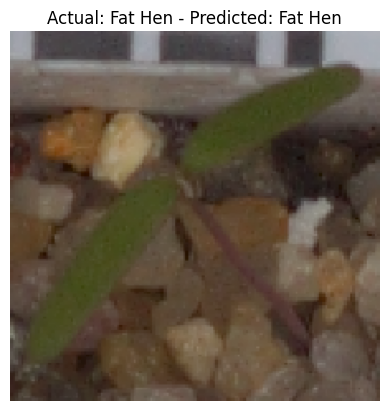

In [25]:
# Displaying these images together
plt.imshow(random_image)
plt.title(f"Actual: {actual_label} - Predicted: {predicted_label}")
plt.axis("off")
plt.show()

In [26]:
# Creating a Confusin Matrix to judge the Model's performance 

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


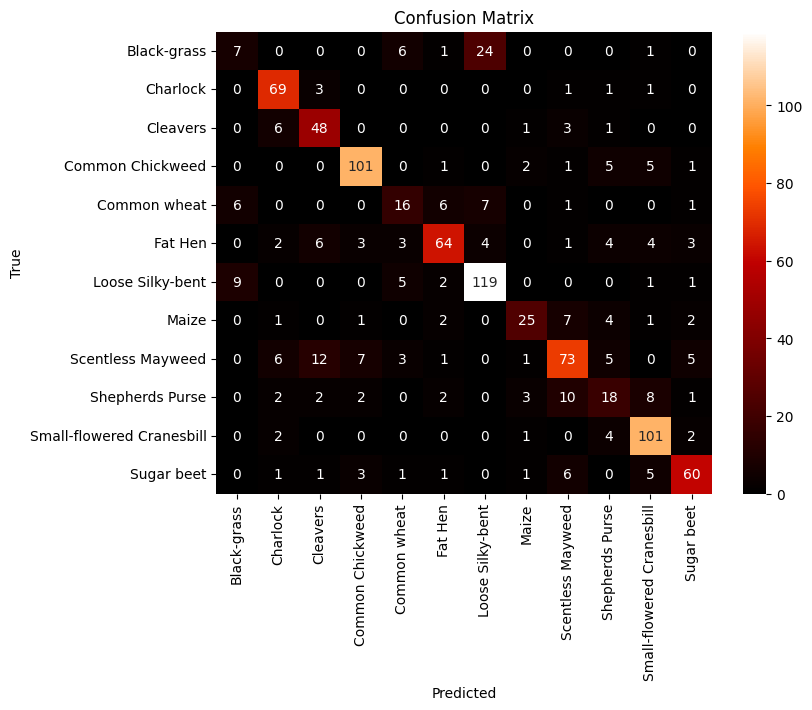

In [27]:
# Creating a heatmap of the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='gist_heat', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Model performance:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [29]:
# Calculating all the related metrics

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1-score:", round(f1,2))

Accuracy: 0.74
Precision: 0.73
Recall: 0.74
F1-score: 0.73


* Model's performance is around 73-74% across all the major performance metrics indicating that the model has done better than random guessing (50%) but the performance can still be improved to a large extent.
* Note: No Image Augumentation techinques were used in building the above CNN model. Using Image Augumentation might have significantly boosted the model's performance.

# Part-2: Botanical Research

In [31]:
# Importing the data - oxflower from the provided file

data = np.load('/kaggle/input/flower-type/oxflower17.npz') 
X = data['X'] 
y = data['Y'] 

In [32]:
# Priniting the dimensions of 'X', 'y'

print("Shape of X:", X.shape,"\n\nShape of Y:", y.shape)

Shape of X: (1360, 224, 224, 3) 

Shape of Y: (1360, 17)


From above, 
* the number of images are: 1360
* Shape of each image is: (224, 224) with 3 channels

In [33]:
#Printing a single row(2nd row) from 'y'

y[1,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
# Count of classes in 'y' with counts

y_classes = np.argmax(y, axis=1)
print("Unique class labels in y:", np.unique(y_classes))

Unique class labels in y: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


#### Hence, there are a total of `17 classes` in y.

* Also, provided the shape of 'y', these classes are all one-hot-encoded

----------

#### Note: No 'class_labels' can be found in the provided file for Ox-flower17. 

* I've tried download the orginal file from 'https://www.robots.ox.ac.uk/~vgg/data/flowers/' but even the original file doesn't have any class labels (I referred - `17 category dataset`)

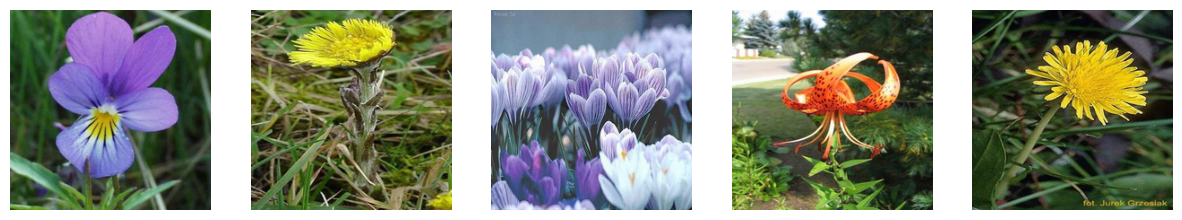

In [35]:
# Displaying 5 Random Images

# Using random library for random number generation

import random

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax in axes:
    idx = random.randint(0, len(X) - 1)
    ax.imshow(X[idx])
    ax.axis('off')

plt.show()

In [36]:
#Selecting a random image from the dataset and assigning it to a variable 

#Again using random function to select any random image 

selected_idx = random.randint(0, len(X) - 1)

selected_img = X[selected_idx]

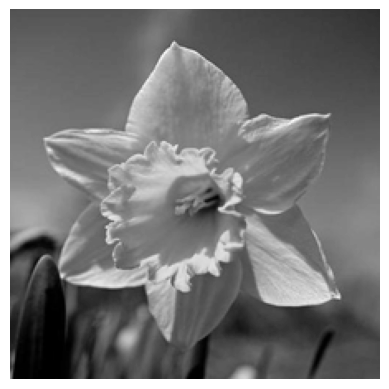

In [37]:
#Transforming the above image into grayscale format and displaying the same

from PIL import Image

selected_image_pil = Image.fromarray((selected_img * 255).astype(np.uint8))
gray_image = selected_image_pil.convert('L')
gray_image_array = np.array(gray_image) / 255

plt.imshow(gray_image_array, cmap='gray')
plt.axis('off')
plt.show()

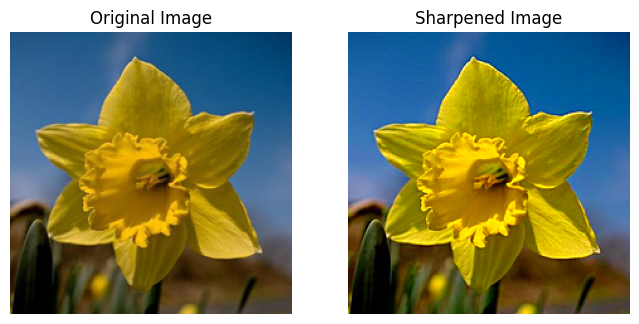

In [38]:
#Sharpening the image

from skimage.filters import unsharp_mask

sharpened_image = unsharp_mask(selected_img, radius=1, amount=1) 

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(selected_img)
plt.title('Original Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sharpened_image)
plt.title('Sharpened Image')
plt.axis('off')
plt.show()

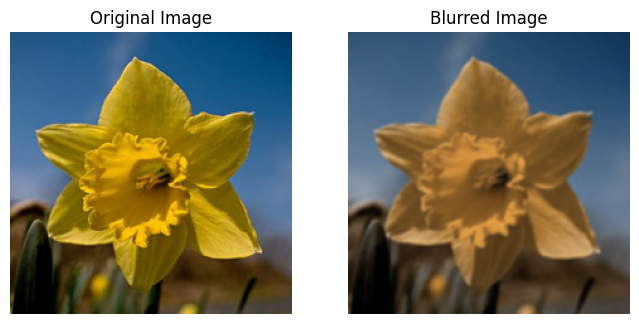

In [39]:
# Applying a filter to blur the image (using Gaussian blur)

from skimage.filters import gaussian

blurred_image = gaussian(selected_img, sigma=1) 

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(selected_img)
plt.title('Original Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(blurred_image)
plt.title('Blurred Image')
plt.axis("off")
plt.show()

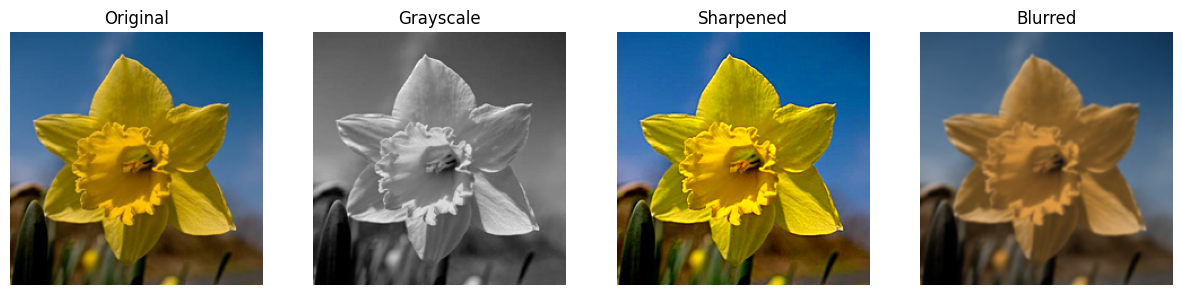

In [40]:
# Displaying all the 4 images from above observe the difference

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(selected_img)
plt.title('Original')
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(gray_image_array, cmap='gray')
plt.title('Grayscale')
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(sharpened_image)
plt.title('Sharpened')
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(blurred_image)
plt.title('Blurred')
plt.axis("off")
plt.show()

### Model Training

In [41]:
#Spliting the data into train and test datasets

from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=79)

In [42]:
#Printing the shapes for each of the training and testing datasets

print("Shape of X1_train is:", X1_train.shape, "\n\nShape of X1_test is:", X1_test.shape, "\n\nShape of y1_train is:", y1_train.shape, "\n\nShape of y1_test is:", y1_test.shape)

Shape of X1_train is: (1088, 224, 224, 3) 

Shape of X1_test is: (272, 224, 224, 3) 

Shape of y1_train is: (1088, 17) 

Shape of y1_test is: (272, 17)


In [43]:
# Converting y's one-hot encoding to class labels

y1_train = np.argmax(y1_train, axis=1)
y1_train

array([ 5, 15, 13, ...,  0, 14, 13])

In [44]:
# Performing the same operation on y_test

y1_test = np.argmax(y1_test, axis=1)
y1_test

array([13, 11, 16,  4, 11,  7,  3,  4, 10,  4,  2,  2,  2, 14,  4, 13, 16,
        5, 10,  6,  4,  4,  8,  2, 14,  5,  1,  7,  9,  5,  4,  9, 15,  5,
        1,  8, 10,  9,  9, 16,  6,  3, 13,  0, 14,  5, 15,  1, 11,  4, 14,
        1,  1,  5, 12, 15, 11,  7, 11,  1,  9, 14, 12, 10,  8, 10, 13, 14,
        8,  6,  0,  8,  2, 12,  9, 15,  5, 13, 10, 14, 15,  5,  7, 16,  0,
       12, 14, 12, 10, 16, 12,  6, 15,  6, 11, 15,  9,  5, 16,  4, 10,  7,
        8, 16,  5, 15,  0,  0, 13,  0,  6,  1, 13,  3, 15,  9, 10,  9,  8,
        5, 11,  3,  8, 11, 11,  1, 11, 11, 16,  5,  3,  1,  5,  1,  1,  4,
       14,  1, 10, 10, 12,  1,  1, 15, 13, 13, 16, 10,  4,  2,  5,  6, 14,
        2,  3, 13, 10,  1,  7, 15, 11,  8, 11,  9,  9,  2, 16, 13,  3,  8,
        4,  8, 11,  4, 12, 15,  2,  3,  2, 11, 13, 12, 15,  6, 10, 10,  6,
        1,  8,  7,  5,  4,  3, 16,  1,  2,  9, 12, 12,  2, 13, 11,  7,  1,
        0, 11,  7,  7,  1,  6,  7, 10,  6, 13,  2,  5,  7,  4,  0, 13,  4,
        9, 15,  2, 15, 14

### Linear Model (SVC)

-- Chose SVC as my Linear Model for this Task

In [45]:
#SVC model (Supervised Learning algorithm)

from sklearn.svm import SVC 

# Creating and training SVM model
svm_model = SVC(kernel='linear') 

svm_model.fit(X1_train.reshape(X1_train.shape[0], -1), y1_train) 

SVC(kernel='linear')

In [46]:
# Making predictions

y1_pred_svm = svm_model.predict(X1_test.reshape(X1_test.shape[0], -1))

In [47]:
# Evaluating SVC model's performance

from sklearn.metrics import accuracy_score, classification_report


accuracy = accuracy_score(y1_test, y1_pred_svm)
print("SVM Accuracy:", accuracy)
print(classification_report(y1_test, y1_pred_svm))

SVM Accuracy: 0.4889705882352941
              precision    recall  f1-score   support

           0       0.22      0.36      0.28        11
           1       0.33      0.45      0.38        20
           2       0.65      0.72      0.68        18
           3       0.42      0.45      0.43        11
           4       0.64      0.50      0.56        18
           5       0.40      0.42      0.41        19
           6       0.50      0.50      0.50        18
           7       0.31      0.38      0.34        13
           8       0.72      0.87      0.79        15
           9       0.41      0.47      0.44        15
          10       0.62      0.45      0.53        22
          11       0.56      0.28      0.37        18
          12       0.50      0.62      0.55        13
          13       0.67      0.35      0.46        17
          14       0.13      0.15      0.14        13
          15       0.56      0.47      0.51        19
          16       1.00      0.92      0.96     

##### * The model's acccuray is 49%. This suggests the model's performing worse than a random guess (50% accuracy)

### ANN Model

In [48]:
# Training a ANN model for the same problem to see the performance

nn_model = Sequential([
    Flatten(input_shape=X1_train.shape[1:]), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(17, activation='softmax') 
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Training the model

nn_model.fit(X1_train, y1_train, epochs=10, batch_size=32, validation_data=(X1_test, y1_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.0917 - loss: 23.4146 - val_accuracy: 0.2279 - val_loss: 5.4689
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2075 - loss: 4.1220 - val_accuracy: 0.1618 - val_loss: 4.4297
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2646 - loss: 2.7770 - val_accuracy: 0.2390 - val_loss: 3.1768
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3751 - loss: 1.9988 - val_accuracy: 0.3088 - val_loss: 2.6981
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4298 - loss: 1.7130 - val_accuracy: 0.2500 - val_loss: 2.6746
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4362 - loss: 1.8535 - val_accuracy: 0.2684 - val_loss: 2.9005
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4762 - loss: 1.6114 - val_accuracy: 0.2757 - val_loss: 3.0447
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6211 - loss: 1.0972 - val_accuracy: 0.3309 - 

In [51]:
# Calculating accuracy of the model

nn_loss, nn_accuracy = nn_model.evaluate(X1_test, y1_test)
print("Neural Network Accuracy:", round(nn_accuracy*100,2),"%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3074 - loss: 2.7687
Neural Network Accuracy: 29.41 %


### CNN Model

In [52]:
# Creating a new CNN model

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X1_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(17, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Training the CNN model
cnn_model.fit(X1_train, y1_train, epochs=10, batch_size=32, validation_data=(X1_test, y1_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.0693 - loss: 6.4101 - val_accuracy: 0.2132 - val_loss: 2.6657
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1838 - loss: 2.5146 - val_accuracy: 0.3603 - val_loss: 2.1256
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3584 - loss: 1.9593 - val_accuracy: 0.4632 - val_loss: 1.7703
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5633 - loss: 1.4703 - val_accuracy: 0.5368 - val_loss: 1.5440
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6912 - loss: 1.0144 - val_accuracy: 0.5184 - val_loss: 1.4696
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8239 - loss: 0.6053 - val_accuracy: 0.5404 - val_loss: 1.4296
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8957 - loss: 0.3788 - val_accuracy: 0.5551 - val_loss: 1.4277
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9106 - loss: 0.2859 - val_accuracy: 0.5625 - v

In [55]:
# Evaluating the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X1_test, y1_test)
print("CNN Accuracy:", round(cnn_accuracy*100,2),"%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5221 - loss: 1.7704
CNN Accuracy: 54.41 %


##### * CNN Model has achieved the highest accuracy of all the other models (SVC, and ANN) with an accuracy of `54%`

-- Though the CNN model's performance is barely better than a random guess, I'll be using this Model in further predicitions tasks

In [56]:
# Making prediction of the 'Predictions.jpg' image

# Load and preprocess the image

img_path = '/kaggle/input/predition/Prediction.jpg' 
img = Image.open(img_path) 
img = img.resize((X1_train.shape[1], X1_train.shape[2])) 
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [57]:
pred_img_classification = cnn_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


In [58]:
predicted_class = np.argmax(pred_img_classification)
predicted_class

7

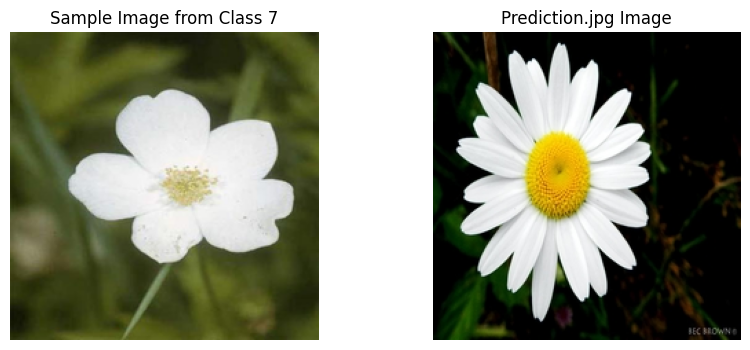

In [62]:
# Displaying the 'Predictions.jpg' image and the image from dataset- OxFlower17 with similar class 

# Find the indices of samples belonging to class 7
class_7_indices = np.where(np.argmax(y, axis=1) == 7)[0]

# Select a random index from the found indices
random_index = np.random.choice(class_7_indices)

# Get the corresponding image
sample_image_class_7 = X[random_index]

# Display the image

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_class_7)
plt.title("Sample Image from Class 7")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('Prediction.jpg Image')
plt.axis("off")
plt.show()

---------------------------------